## 05. Preliminary comparison of the $f_{\rm MM}$ between simulation and data

The notebook is similar to the notebook 02, which builds a major merger catalog. However, here things are done slightly differently: (1) halo pairs are generated, (2) the criteria are applied, rather than the other way around (as shown in notebook 02).

1. Loading data and defining input parameters
2. Finding pairs and creating a major/minor sample
2. Studying merger fraction $f_{MM}$ as a function of redshift

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 23rd April 2021

Import required packages

In [1]:
# scipy modules
from scipy.spatial import cKDTree

# astropy modules
import astropy.units as u
import astropy.io.fits as fits

from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, z_at_value

import numpy as np

# system imports
import os
import sys
import importlib as ib

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Load the imported file(s) that contains all the functions used in this notebooks

In [2]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('imported_files/')
import Exploring_DM_Halos as edh
import Agn_incidence_from_Major_Mergers as aimm
import Comparison_simulation_with_literature_data as cswl
import plotting_cswl05 as pt

### 1. Defining input parameters

In [5]:
# look back into redshifts until...
redshift_limit = 2

# pixel number from the simulation file
pixel_no = '000000'

# define color palatte
pal = sns.hls_palette(10, h=.5, s=1).as_hex()

Define cosmology used in the notebook

In [6]:
cosmo = FlatLambdaCDM(H0=67.77*u.km/u.s/u.Mpc, Om0=0.307115)
h = 0.6777
L_box = 1000.0 / h

Parameters for creating the Major Merger catalogue.

In [8]:
# get shell volume and projected radius bins [Mpc]
r_p, dr_p, shell_volume = aimm.shellVolume()

# time since merger [Gyr]
time_since_merger = 5

# time since merger array [Gyr]
dt_m_arr = [0.5, 1, 2, 3, 4]

# max mass ratio to classify as a major merger [dimensionless]
mass_max = 3

# defining the redshift bin for a merger in terms of dv = c*z [km/s]
dv_cut =  500

xoff_cut = 100

Booleans if one wants to skip running parts of the code

In [9]:
# if the pairs have already been computed before
run_find_pairs = False

# if we want to find all pairs (not just major pairs)
major_mergers_only = False

# if we want to find pairs passing the time since merger criteria
run_merger_pairs = False

### 2. Open files and get relevant data

In [10]:
_, hd_halo, _ = edh.getHeaders(pixel_no, np.array(['agn', 'halo']))

Extracting positions and redshifts of the AGNs, galaxies, and halos

In [11]:
# halos
_, _, conditions_halo = edh.getGalaxyData(hd_halo, '', redshift_limit)
hd_z_halo = hd_halo[conditions_halo]
print("Halos: %d"%(len(hd_z_halo) ))

Halos: 4506611


### 3.  Finding halo pairs

Get the `hd_file` for all the halo pairs. A quick test to understand how many pairs exists as a function of separation (without any regards to $M^*$, $\Delta t_{\rm MM}$, and $\Delta v$

In [ ]:
total_num_pairs = aimm.findPairs(hd_halo[conditions_halo])

Note that here the definition of fraction of halo pairs is different to that used later in the notebook.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

# normalization
r_p, _, shell_volume = aimm.shellVolume()
N = len(hd_halo[conditions_halo])*(len(hd_halo[conditions_halo])-1)

# converting all units to kpc [vol: pc -> kpc; radius: Mpc -> kpc]

ax.plot( (1e3*r_p[1:]), total_num_pairs/(N*shell_volume*1e9), 'kx')

pt.setLabel(ax, r'Separation, $r$ [kpc]', r'$f_{\rm halo\ pairs}}$ [Mpc$^{-3}$]', '', 'default', 'default', legend=False)
plt.savefig('figures/f_halo_pairs.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

Default values at points:
1. `mass_min = 0.33`, `mass_max = 3`
2. `dv_cut = 500`  

Can change these keywords in functions 1 and 2, respectively.

In [ ]:
if run_find_pairs:
    for r in [11]:
        print('\n ---- pairs within radius %.2f Mpc ---'%r_p[r])
        pos_spherical = aimm.getSphericalCoord(hd_halo[conditions_halo])

        # create tree
        tree_data = cKDTree(np.transpose(np.abs(pos_spherical)), leafsize=1000.0)

        # list of lists of all pair indicies per DM halo
        pairs_idx = tree_data.query_ball_tree(tree_data, r=r_p[r], p=2) 
        count_pairs, _ = cswl.countPairs(pairs_idx) 
        
        if major_mergers_only:
            # (1) choose only major pairs (major mergers)
            all_mm_idx, count_major_pairs = cswl.majorMergerSelection(hd_halo[conditions_halo], pairs_idx)
            pairs_idx = all_mm_idx
            
        # (2) choose only major pairs that satisfy the delta v criteria
        all_dv_idx, count_dv_major_pairs = cswl.deltaVelSelection(hd_halo[conditions_halo], pairs_idx, mm = major_mergers_only)
        
        # save file
        np.save('Data/pairs_z%d/pairs_idx_r%d_mm%d_dv%d.npy'%(redshift_limit, r, mass_max, dv_cut), all_dv_idx, allow_pickle=True)


 ---- pairs within radius 0.11 Mpc ---


The pairs computed in the last step is written to the directory `'Data/pos_z2/'`. Here, the pair indicies generated from the ball tree algorithm are loaded for further analysis.

In [23]:
ib.reload(cswl)
pairs_all = cswl.openPairsFiles(key = 'all')
pairs_mm_all = cswl.openPairsFiles(key = 'mm and dv')

Apply the time since major merger criteria. Change keyword `t_since_merger = 1`.

In [16]:
if run_merger_pairs:
    count_t_mm_arr_all_radius = np.zeros( (0, len(r_p) ) )

    for dt_m in dt_m_arr[0:1]:
        count_t_mm_arr = []

        for r in range(len(r_p)):    
            _, count_t_mm = cswl.defineTimeSinceMergeCut(hd_halo[conditions_halo], pairs_all[0][r], cosmo, time_since_merger = dt_m)
            count_t_mm_arr.append(count_t_mm)

        # save the counts for all radius bins for a given time since merger
        count_t_mm_arr_all_radius = np.append(count_t_mm_arr_all_radius, [count_t_mm_arr], axis=0)

    np.save('Data/pairs_z%d/all_pairs_t_mm%.1f_r.npy'%(redshift_limit, dt_m), count_t_mm_arr_all_radius, allow_pickle=True)
else:
    n_pairs_dt_all = cswl.concatAllTmmFiles(dt_m_arr, key = 'all')
    n_pairs_mm_dt_all = cswl.concatAllTmmFiles(dt_m_arr, key = 'mm and dv')

### 4. Studying the effect of $\Delta t_{\rm merger}$ on MM pairs

Now that all the pairs for the chosen cases of time since major mergers are computed, we can proceed to calculate the fraction of halo pairs for each case.

$$f_{\rm halo\ pairs} = \frac{\rm NP}{\rm N(N-1) \times {\rm Shell\ volume}}$$

where $NP$ is the number of pairs and $N$ is the total number of objects from which pairs are chosen.

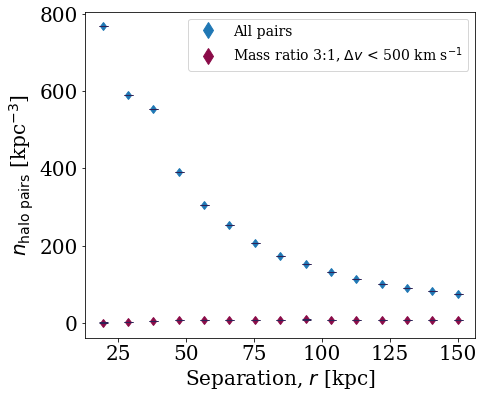

In [24]:
# get number density of pairs with and without selection cuts
f_pairs, f_pairs_err = cswl.nPairsToFracPairs(hd_z_halo, pairs_all[1])
f_mm_pairs, f_pairs_mm_err = cswl.nPairsToFracPairs(hd_z_halo, pairs_mm_all[1])

fig, ax = plt.subplots(1,1,figsize=(7,6))

# changing all unit to kpc
r_p_kpc, f_pairs, f_mm_pairs = 1e3*r_p[1:], 1e9*f_pairs, 1e9*f_mm_pairs

# plotting the results
all_pairs = ax.plot( r_p_kpc , f_pairs, 'd',  label='All pairs')
mm_pairs =  ax.plot( r_p_kpc , f_mm_pairs, 'd', color='#8a0b48', label=r'Mass ratio 3:1, $\Delta v$ < 500 km s$^{-1}$')

# errorbars
ax.errorbar(r_p_kpc , np.array(f_pairs), yerr=f_pairs_err, ecolor='#2f2357', fmt='none', capsize=4.5)
ax.errorbar(r_p_kpc , np.array(f_mm_pairs), yerr=f_pairs_mm_err, ecolor='#2f2357', fmt='none', capsize=4.5)

pt.setLabel(ax, r'Separation, $r$ [kpc]', r'$n_{\rm halo\ pairs}}$ [kpc$^{-3}$]', '', 'default', 'default', legend=True)
plt.savefig('figures/f_halo_pairs.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

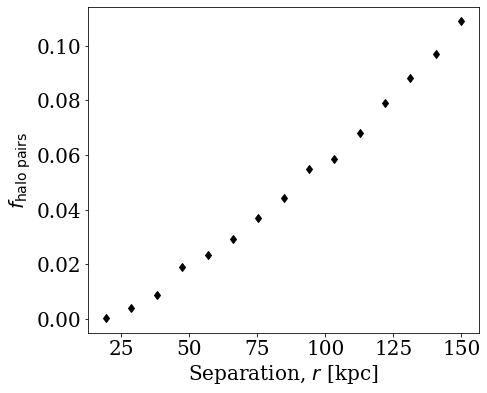

In [20]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.plot( r_p_kpc , f_mm_pairs/f_pairs, 'kd')
pt.setLabel(ax, r'Separation, $r$ [kpc]', r'$f_{\rm halo\ pairs}}$', '', 'default', 'default', legend=False)

Plot shows that the major merger (mass ratio) criteria encompasses the $\Delta v$ criterion in redshift. So by imposing mass ratio, we are automatically selecting only those pairs that are close to each other in redshfit i.e. $\Delta v = c \Delta z$.

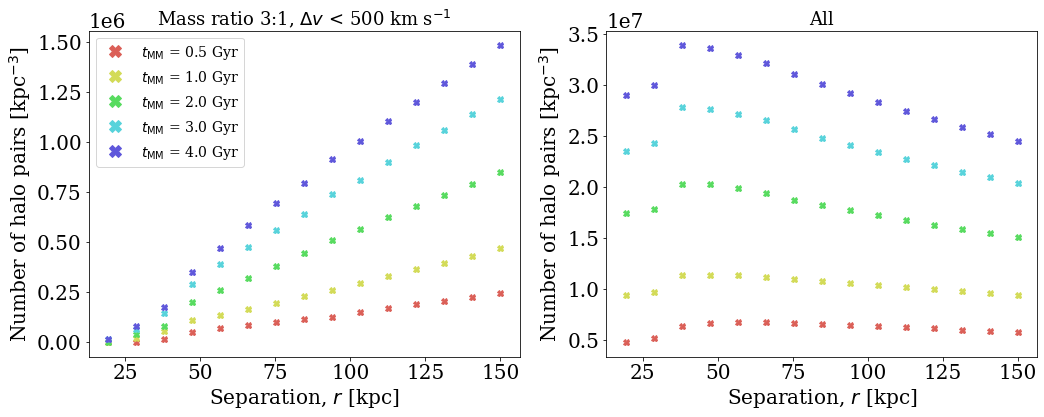

In [25]:
fig, ax = plt.subplots(1,2,figsize=(17,6))
pal = sns.color_palette("hls", len(dt_m_arr)+1).as_hex()
errorbars = [False, False, False, False, False]

for t_idx in range(len(dt_m_arr)):
    np_dt, np_mm_dt = n_pairs_dt_all[t_idx], n_pairs_mm_dt_all[t_idx]    
    ax[0].plot( (1e3*r_p[1:]), np_mm_dt[1:]/shell_volume, 'kX', label = r'$t_{\rm MM}$ = %.1f Gyr'%dt_m_arr[t_idx], color=pal[t_idx])
    ax[1].plot( (1e3*r_p[1:]), np_dt[1:]/shell_volume, 'kX', color=pal[t_idx])

pt.setLabel(ax[0], r'Separation, $r$ [kpc]', r'Number of halo pairs [kpc$^{-3}$]', r'Mass ratio 3:1, $\Delta v$ < 500 km s$^{-1}$', 'default', 'default', legend=True)
pt.setLabel(ax[1], r'Separation, $r$ [kpc]', r'Number of halo pairs [kpc$^{-3}$]', 'All', 'default', 'default', legend=False)

$$f_{\rm halo pairs} = \frac{n_{\rm pairs}(\rm Mass\ ratio\ < 3:1; \Delta \ v < 500 km\ s^{-1};\ T_{mm}=t)}{n_{\rm total\ pairs}}$$

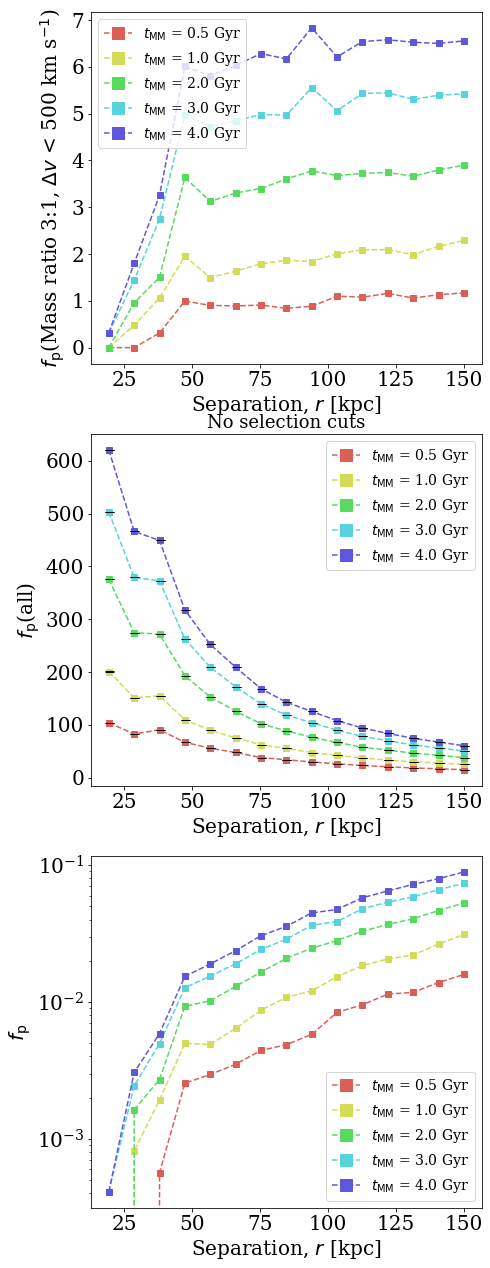

In [27]:
ib.reload(pt)
fig, ax = plt.subplots(3,1,figsize=(7,22))

for t_idx in range(len(dt_m_arr)):
    np_dt, np_mm_dt = n_pairs_dt_all[t_idx], n_pairs_mm_dt_all[t_idx]    
    f_p, f_p_err = cswl.nPairsToFracPairs(hd_z_halo, np_dt)
    f_p_mm, f_p_mm_err = cswl.nPairsToFracPairs(hd_z_halo, np_mm_dt)
    
    # plot 1 and 2
    _ = pt.plotFpairs(ax[0], r_p, f_p_mm, f_p_mm_err, label = r'$t_{\rm MM}$ = %.1f Gyr'%dt_m_arr[t_idx], color=pal[t_idx], errorbar = False)
    _ = pt.plotFpairs(ax[1], r_p, f_p, f_p_err, label = r'$t_{\rm MM}$ = %.1f Gyr'%dt_m_arr[t_idx], color=pal[t_idx], errorbar = True)
    
    norm = 2*len(hd_z_halo)*(len(hd_z_halo)-1)*shell_volume
    _ = pt.plotFpairs(ax[2], r_p, f_p_mm/f_pairs, f_p_err, label = r'$t_{\rm MM}$ = %.1f Gyr'%dt_m_arr[t_idx], color=pal[t_idx], errorbar = False)
    
pt.setLabel(ax[0], r'Separation, $r$ [kpc]', r'$f_{\rm p}}$(Mass ratio 3:1, $\Delta v$ < 500 km s$^{-1}$) ', '', 'default', 'default', legend=True)
pt.setLabel(ax[1], r'Separation, $r$ [kpc]', r'$f_{\rm p}}$(all) ', 'No selection cuts', 'default', 'default', legend=True)
pt.setLabel(ax[2], r'Separation, $r$ [kpc]', r'$f_{\rm p}}$', '', 'default', 'default', legend=True)

ax[2].set_yscale('log')
plt.savefig('figures/f_halo_pairs_dt.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

Let's look at the distribution of the scale factor of the chosen pairs.

In [55]:
halo_m_scale_arr_all_r = cswl.getAllMMscales(hd_halo[conditions_halo], pairs_mm_all, r_p)

TO BE UPDATED: The selection applied is to choose pairs > $t_{\rm MM}$ lines. 

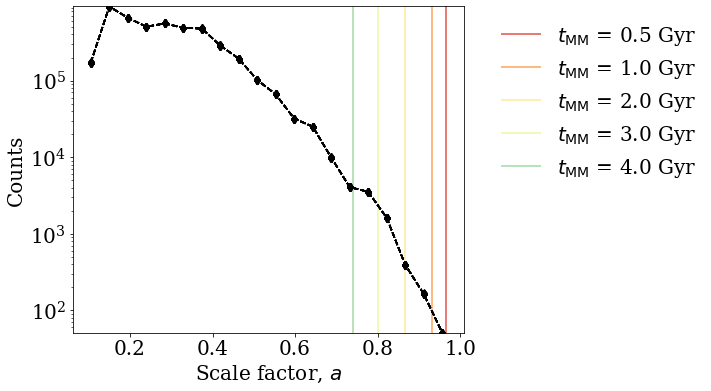

In [71]:
pt.plotScaleMMdistribution(halo_m_scale_arr_all_r, cosmo, dt_m_arr)

### 5. Quantifying morphology with X$_{\rm off}$

TODO: Divide my $R_{\rm vir}$

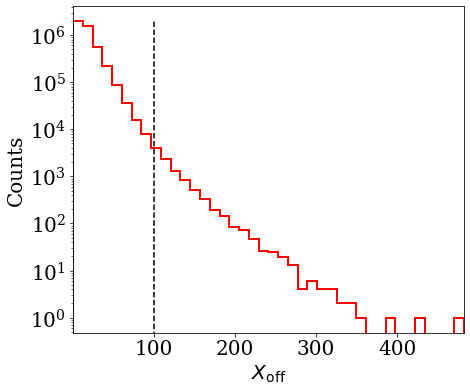

In [35]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

hd_halo_z = hd_halo[conditions_halo]

counts_xoff, _, _ = ax.hist(hd_halo_z['HALO_Xoff'], bins=40, histtype='step', color='r', lw=2)
ax.vlines(xoff_cut, np.min(counts_xoff), np.max(counts_xoff), linestyles='--', colors='k')

xoff_min, xoff_max = np.min(hd_halo_z['HALO_Xoff']), np.max(hd_halo_z['HALO_Xoff'])
pt.setLabel(ax, r'$X_{\rm off}$', r'Counts', '', [xoff_min, xoff_max], 'default', legend=False)
ax.set_yscale('log')